# Example of rough simulation with adhesion on the contact challenge 512x512 topography

The adhesion is longer ranged in this example than in the original contact challenge problem definitition because we use a much coarser grid here. 

In [182]:
from SurfaceTopography import read_published_container
import Adhesion # required to register the "make_system" function
from Adhesion.Interactions import Exponential
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import LinearSegmentedColormap

In [2]:
c, = read_published_container("https://doi.org/10.57703/ce-vrcd9")

In [3]:
t = c._topographies[0].to_unit("m")

In [40]:
t.parent_topography.parent_topography.parent_topography._periodic = True
#TODO: temporary tweak becaus the published topography has wrong peridic property

In [41]:
t.is_periodic

True

In [42]:
t._periodic = True

In [43]:
t.rms_gradient()

0.7336383107367028

In [44]:
t.rms_height_from_area()

7.621658676206695e-07

In [45]:
1/t.rms_curvature_from_area()

3.9854089287689417e-07

In [46]:
Es = 25e6 # N / m2
challenge_wint = 0.05 # mJ / m2
challenge_rho = 2.071e-9 # interaction_range in the contact challenge
# External load 250 kPa
challenge_external_pressure = 250e3 # Pa

## Defining meaningful numerical tolerances

In adhesive simulations, the optimisation variable is the displacement. 
The algorithm seeks the minimum of the total energy $\Pi_\mathrm{tot}$, where the residual $\partial \Pi_\mathrm{tot}/\partial u_{ij} = 0$

A typical repulsive contact pressure is $E^\prime h^\prime_{rms}$, leading to the typical repulsive pixel force $E^\prime h^\prime_{rms} \Delta x^2$. 
We use a small fraction of this typical force as the numerical tolerance for the residual: 

In [82]:
pixel_force_tol = 1e-5 * Es * t.rms_gradient() * t.area_per_pt

Another valid choice of "typical pressure" would be to use the maximum interaction force. 

In dual minimizers (used in the nonadhesive contact system), the residual is the gap inside the contact area. Let's use a typical change of heights for the tolerance

In [83]:
penetration_tol = 1e-3 * t.rms_gradient() * t.pixel_size[0]

### Nonadhesive contact system

In [86]:
nonadhesive_system = t.make_contact_system(interaction="hardwall", young=Es)

In [87]:
sol = nonadhesive_system.minimize_proxy(external_force=np.prod(t.physical_sizes) 
                                        * challenge_external_pressure, pentol=penetration_tol)

In [89]:
nonadhesive_offset = sol.offset

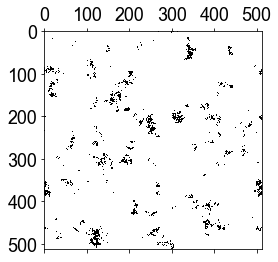

In [176]:
fig,ax=plt.subplots()
cmap = LinearSegmentedColormap.from_list('contactcmap', ((1,1,1,0.), "black"), N=256)
ax.matshow(nonadhesive_system.contact_zone.T, cmap = cmap)
ax.grid(False)

### contact system with hardwall repulsion

In [93]:
from Adhesion.Interactions import Exponential
from Adhesion.System import BoundedSmoothContactSystem

In [127]:
interaction=Exponential(gamma0=challenge_wint ,rho=challenge_rho*30)

In [128]:
w = -interaction.evaluate(0)[0]

In [129]:
dx = t.pixel_size[0]

### Properties of the adhesive rough contact

##### Energy for full conformal contact

In [184]:
print("Persson and Tosatti adhesion criterion: ")
print(
    "elastic deformation energy for full contact / work of adhesion: "
    "{}".format(nonadhesive_system.substrate.evaluate(t.detrend(detrend_mode="center").heights())[0]
                / w / np.prod(t.physical_sizes)))  # ^
#                           sets the mean to zero, so         |
#                           that the energy of the q = 0   --
#                           mode is not taken into
#                           account

##### Pastewka and Robbins criterion
P&R equation 10, with kappa_rep = 2, d_rep=4 h'rms / h''rms
(Only valid in the DMT regime, i.e. until the onset of stickiness)
If this value is smaller then 1 the surfaces are sticky and
normal CG's might not work anymore

A requirement for the Pastewka Robbins theory to be valid is that the interaction is short ranged enough. 
See below. 

In [185]:
rho = interaction.rho


print("P&R stickiness criterion: "
      "{}".format(t.rms_gradient() * Es * rho / 2 / w *
                  (t.rms_gradient() ** 2 / t.rms_curvature_from_area() / rho)
                  ** (2 / 3)))

R = 1 / t.rms_curvature_from_area()
elastocapillary_length = w / Es
print("Generalized Tabor parameter following Martin Müser")
print("{}".format(
    R ** (1 / 3) * elastocapillary_length ** (2 / 3) / rho))

P&R stickiness criterion: 26.03037299764939
Generalized Tabor parameter following Martin Müser
0.18802240638058187


Is the Pastewka Robbins assumption of short-ranged adhesion valid ? 

In [186]:
print("rms_height / interaction_length: "
      "{}".format(t.rms_height_from_area() / interaction.rho))

rms_height / interaction_length: 12.267276156778841


[Monti Sanner and Pastewka 2021](https://doi.org/10.1007/s11249-021-01454-6)

In [187]:
g0 = 16 /3 * t.rms_gradient()**2 / t.rms_curvature_from_area()

In [188]:
g0

1.1440252811276187e-06

In [189]:
print("rho / g0: "
      "{}".format(g0 / interaction.rho))

rho / g0: 18.413411896468997


This value should be smaller than 0.1 for the assumptions behind the Pastewka and Robbins theory to be valid. We hence cannot apply the theory to the system considered here.

#### Estimate whether the discretisation is alright

##### Process zone in a crack

In [193]:
process_zone_size = Es * w / np.pi / abs(interaction.max_tensile) ** 2

print("nb pixels in process zone: {}".format(process_zone_size / dx))
# print("highcut wavelength / process_zone size: "
#       "{}".format(short_cutoff / process_zone_size))


nb pixels in process zone: 3.145522527469698


##### Empirical criterion on contact of spheres (see [adhesive_simulation_sphere.ipynb]())
$$
dx \leq 2 \rho^2 \frac{4}{3\pi} \frac{1}{\ell_a}
$$

The value below should be greater than 1: 

In [194]:
interaction.rho ** 2 * 8 / 3 / np.pi * Es / w / dx

8.388060073252527

##### [Wang, Zhou and Müser 2021](https://doi.org/10.3390/lubricants9020017) Equation (9) and Fig.8:

$\mu_{rho}$

In [195]:
np.sqrt(- interaction.evaluate(0, True, True, True)[-1] # min curvature for the exponential interaction
                 / Es * dx
                )

0.3181109830364135

should be smaller than 0.5

### Adhesive simulation

In [196]:
system = t.make_contact_system(interaction=interaction, young=Es, system_class=BoundedSmoothContactSystem)

In [143]:
sol=system.minimize_proxy(
               offset=nonadhesive_offset, 
               # tol=pixel_force_tol, 
               lbounds="auto",
                options=dict(
                    ftol=0,
                    gtol=pixel_force_tol,
                    maxcor=3,
                    maxiter=1000,
                    )
                         )
assert sol.success

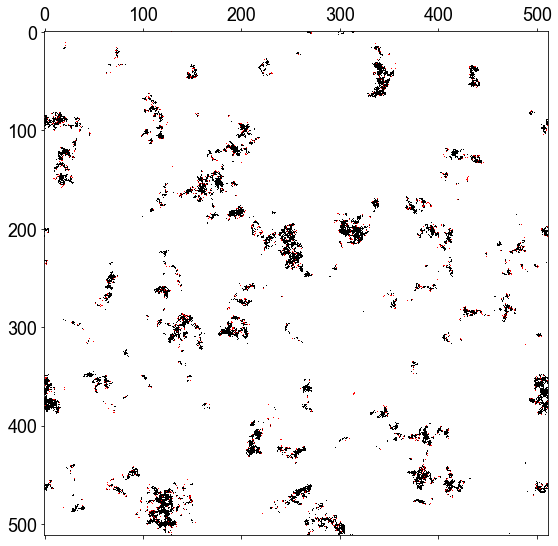

In [177]:
fig,ax=plt.subplots(figsize=(10, 10))
color = "red"
cmap = LinearSegmentedColormap.from_list('contactcmap', ((1,1,1,0.), color), N=256)
ax.matshow(system.contact_zone.T, cmap = cmap)
cmap = LinearSegmentedColormap.from_list('contactcmap', ((1,1,1,0.), "black"), N=256)
ax.matshow(nonadhesive_system.contact_zone.T, cmap = cmap)

ax.grid(False)

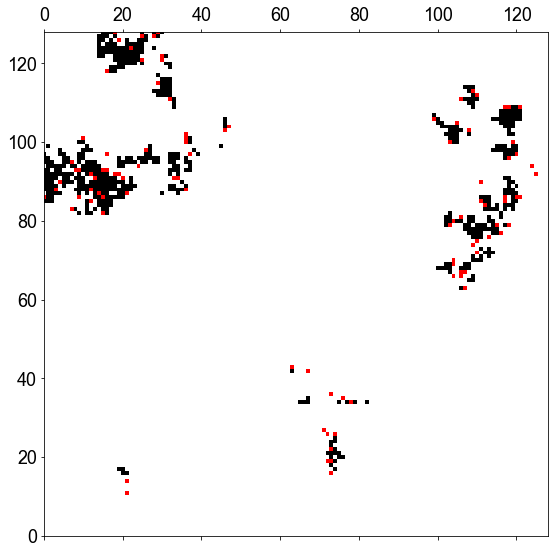

In [178]:
ax.set_xlim(0, 128)
ax.set_ylim(0, 128)
fig

Gaps

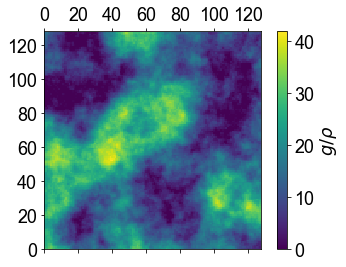

In [179]:
fig,ax=plt.subplots()
plt.colorbar(ax.matshow(system.gap[:128,:128].T / interaction.rho), label=r"$g/\rho$")
ax.set_xlim(0, 128)
ax.set_ylim(0, 128)

ax.grid(False)

### How adhesion affected the mean pressure (in MPa)

In [180]:
system.compute_normal_force() / np.prod(t.physical_sizes) / 1000

245.56262278292817

In [181]:
nonadhesive_system.compute_normal_force() / np.prod(t.physical_sizes) / 1000

249.99999999999994

## Further examples


- [../test/test_bugnicourt_primal_rough_weakly_adhesive.py]()